In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
import numpy as np
import requests
from talib import MACD, RSI, BBANDS
from datetime import datetime, timedelta, date
from IPython.display import display, HTML
from liualgotrader.common import config
%matplotlib inline
import json
import math
from dateutil import parser
from pytz import timezone
import pytz
import sys
import iso8601
import asyncio
from pandas import DataFrame as df
from liualgotrader.analytics.analysis import (
    load_trades_by_batch_id,
    calc_batch_revenue,
    count_trades,
)
from liualgotrader.common.market_data import get_historical_data_from_poylgon_for_symbols
import nest_asyncio
nest_asyncio.apply()

In [2]:
batch_id = "ad465fb4-6e17-4e6d-9318-3d718c6deef5"

In [3]:
api = tradeapi.REST(base_url="https://api.alpaca.markets")

In [4]:
trades = load_trades_by_batch_id(batch_id)

[94753]2020-10-26 09:45:56.303222:db connection pool initialized


In [5]:
day_to_analyze = min(trades['client_time'].tolist())
config.market_open = day_to_analyze.replace(hour=9, minute=30, second=0, microsecond=0)

In [6]:
how_was_my_batch = pd.DataFrame()
trades["client_time"] = pd.to_datetime(trades["client_time"])
how_was_my_batch["symbol"] = trades.symbol.unique()
how_was_my_batch["revenues"] = how_was_my_batch["symbol"].apply(
    lambda x: calc_batch_revenue(x, trades, batch_id)
)
how_was_my_batch["count"] = how_was_my_batch["symbol"].apply(
    lambda x: count_trades(x, trades, batch_id)
)

In [7]:
pd.set_option('display.max_rows', how_was_my_batch.shape[0]+1)
how_was_my_batch

,symbol,revenues,count
0,BKD,22.32,2
1,CARV,-26.62,2
2,CHFS,81.90,2
3,FNKO,47.43,2
4,GEO,-100.65,2
5,HP,-99.11,2
6,IEA,24.83,2
7,JDST,-15.15,2
8,MFA,8.43,2
9,MRIN,57.39,6


In [8]:
print(f"Revenue: ${round(sum(how_was_my_batch['revenues'].tolist()), 2)}")

Revenue: $-111.02


In [9]:

minute_history = get_historical_data_from_poylgon_for_symbols(
    api,
    trades.symbol.unique().tolist(),
    day_to_analyze - timedelta(days=7),
    day_to_analyze + timedelta(days=1),
)

BKD analysis with profit 22.32


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1930.68,-1930.68,buy,2020-10-23 10:25:00-04:00,3.46,558,3.59%,,"{'avg': 3.3765833495289734, 'macd': [0.014339670663056303, 0.014079387899299523, 0.014512734589811505, 0.01628230553434573, 0.019078609772549715], 'vwap': 3.4516666666666667, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.014982052643876923, 0.014801519694961443, 0.014743762673931456, 0.015051471246014312, 0.01585689895132139]}",4.00,3.28
1,22.32,1953.00,sell,2020-10-23 10:28:00-04:00,3.50,558,4.79%,,"{'avg': 3.391990857192526, 'rsi': [76.32991374385662, 76.32991374385662, 79.37636725898024], 'vwap': 3.4933333333333336, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.011560693641618507, 'sell_macd': [0.009552774633462047, 0.011357987855017626, 0.013656102211359489, 0.01526948869407585, 0.017021008610988098], 'sell_macd_signal': [0.00879557094443667, 0.00930805432655286, 0.010177663903514187, 0.01119602886162652, 0.012361024811498835]}",4.00,3.28


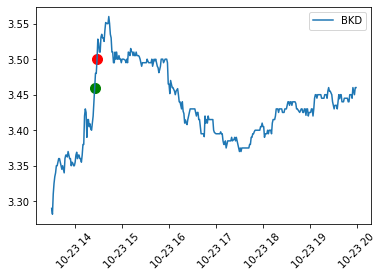

CARV analysis with profit -26.62


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1829.52,-1829.52,buy,2020-10-23 10:09:00-04:00,7.56,242,5.28%,,"{'avg': 7.349945636530311, 'macd': [0.059048896969303044, 0.0583437255918513, 0.05912065712698933, 0.06724023987244454, 0.07145540880552304], 'vwap': 7.566766666666666, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.05988780005531914, 0.059578985162625574, 0.059487319555498325, 0.06103790361888757, 0.06312140465621466]}",8.80,7.15
1,-26.62,1802.90,sell,2020-10-23 15:59:00-04:00,7.45,242,3.75%,,{'liquidate': 1},None,None


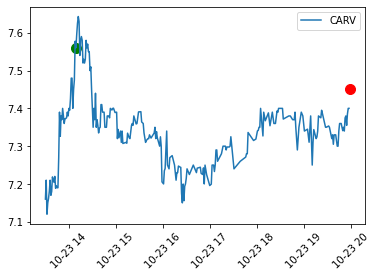

CHFS analysis with profit 81.90


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2663.70,-2663.70,buy,2020-10-23 10:53:00-04:00,6.83,390,3.96%,,"{'avg': 6.776227063035923, 'macd': [-0.01924504838871499, -0.01528473723951329, -0.008027117538691897, -0.0030392147242164214, 0.0032964836600495317], 'vwap': 6.8133333333333335, 'reason': ['MACD zero-cross'], 'macd_signal': [-0.019274341204729258, -0.018476420411686064, -0.01638655983708723, -0.01371709081451307, -0.010314375919600549]}",7.60,6.57
1,81.90,2745.60,sell,2020-10-23 11:16:00-04:00,7.04,390,7.15%,,"{'avg': 6.847924545337321, 'rsi': [67.83341638863733, 64.48683470305733, 58.84370966801453], 'vwap': 7.0759333333333325, 'reasons': 'bail', 'movement': 0.03131771595900436, 'sell_macd': [0.04796578032258214, 0.04767289282497167, 0.04711644941352233, 0.04503199416546444, 0.04261165681850798], 'sell_macd_signal': [0.04224311738359014, 0.043329072471866445, 0.044086547860197625, 0.04427563712125099, 0.043942841060702384]}",7.60,6.57


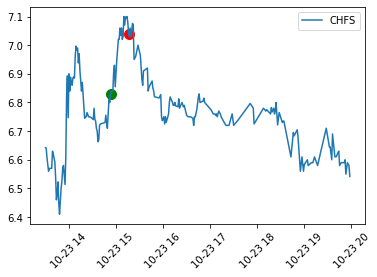

FNKO analysis with profit 47.43


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-3277.94,-3277.94,buy,2020-10-23 10:30:00-04:00,6.22,527,1.63%,,"{'avg': 6.165740759505185, 'macd': [0.010328563810335645, 0.01151453989385054, 0.013110224404937476, 0.013413279512997534, 0.015492159959334728], 'vwap': 6.2250000000000005, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.013654615053336575, 0.013226600021439367, 0.01320332489813899, 0.013245315821110697, 0.013694684648755503]}",6.79,6.04
1,47.43,3325.37,sell,2020-10-23 11:22:00-04:00,6.31,527,3.1%,,"{'avg': 6.23251630118314, 'rsi': [55.56032667390982, 55.56032667390982, 53.13713797341501], 'vwap': 6.306666666666666, 'reasons': 'bail', 'movement': 0.013654618473895578, 'sell_macd': [0.014575585937567581, 0.014712471607152722, 0.01358910366647681, 0.012537270158593294, 0.010862197249958072], 'sell_macd_signal': [0.013334389953548584, 0.013610006284269411, 0.01360582576071089, 0.013392114640287372, 0.012886131162221513]}",6.79,6.04


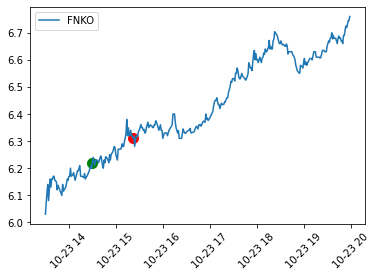

GEO analysis with profit -100.65


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2873.10,-2873.10,buy,2020-10-23 10:03:00-04:00,9.42,305,1.73%,,"{'avg': 9.291951590782716, 'macd': [0.03797712044429957, 0.04053905184844098, 0.044477441958825636, 0.04617073971529351, 0.047768956023464426], 'vwap': 9.417966666666667, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.0476872218542224, 0.04625758785306612, 0.045901558674218024, 0.04595539488243312, 0.046318107110639384]}",10.40,9.09
1,-100.65,2772.45,sell,2020-10-23 11:40:00-04:00,9.09,305,-1.84%,,"{'avg': 9.303972985563558, 'rsi': [44.7429902437211, 36.733332725333, 32.924876015974654], 'vwap': 9.089566666666668, 'reasons': 'stopped', 'movement': -0.035449999469152435, 'sell_macd': [-0.0009931061262076213, -0.0013988560599695887, -0.001696857877705682, -0.003205731269737555, -0.004881835238380816], 'sell_macd_signal': [-0.0030551115181982535, -0.0027238604265525206, -0.0025184599167831527, -0.002655914187374033, -0.0031010983975753898]}",10.40,9.09


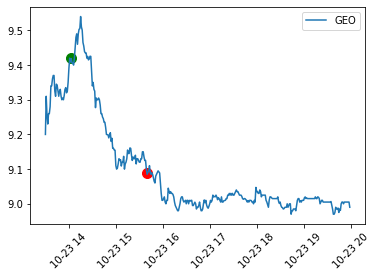

HP analysis with profit -99.11


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2986.39,-2986.39,buy,2020-10-23 10:31:00-04:00,15.97,187,3.17%,,"{'avg': 15.69523888074037, 'macd': [0.03990548885911949, 0.04165109859102145, 0.044139526744608304, 0.05117018097611137, 0.05649425274180686], 'vwap': 15.975, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.054066148341270395, 0.051583138391220605, 0.05009441606189814, 0.050309569044740786, 0.051546505784154]}",17.58,15.44
1,-99.11,2887.28,sell,2020-10-23 14:36:00-04:00,15.44,187,-0.26%,,"{'avg': 15.737863840560024, 'rsi': [31.32772244270159, 33.31114898490066, 30.46809019646765], 'vwap': 15.438333333333333, 'reasons': 'stopped', 'movement': -0.03348982785602505, 'sell_macd': [-0.01909864515169346, -0.017594132819418462, -0.017751731874534826, -0.01738425410093214, -0.01773793911585919], 'sell_macd_signal': [-0.025084367250133983, -0.02358632036399088, -0.02241940266609967, -0.021412372953066163, -0.020677486185624767]}",17.58,15.44


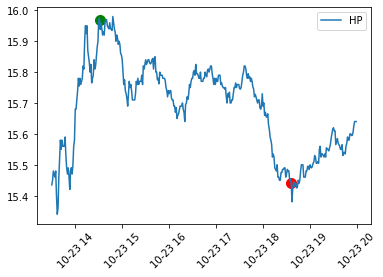

IEA analysis with profit 24.83


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1648.33,-1648.33,buy,2020-10-23 10:06:00-04:00,8.63,191,4.23%,,"{'avg': 8.468505684581977, 'macd': [0.03459622275078367, 0.034342700451530206, 0.03758973910081487, 0.043047792297823406, 0.06039472523225875], 'vwap': 8.573300000000001, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.0388941394738878, 0.03798385166941628, 0.037905029155696, 0.03893358178412148, 0.04322581047374893]}",10.19,8.11
1,24.83,1673.16,sell,2020-10-23 10:19:00-04:00,8.76,191,5.8%,,"{'avg': 8.552689400654275, 'rsi': [60.973115546311504, 60.161951712339935, 57.566714503677254], 'vwap': 8.781866666666666, 'reasons': 'bail', 'movement': 0.015388180764773994, 'sell_macd': [0.07658916648079916, 0.07662596130358423, 0.07695819153817496, 0.0754383944282715, 0.07181294567040197], 'sell_macd_signal': [0.0700714655081966, 0.07138236466727413, 0.07249753004145429, 0.07308570291881773, 0.07283115146913458]}",10.19,8.11


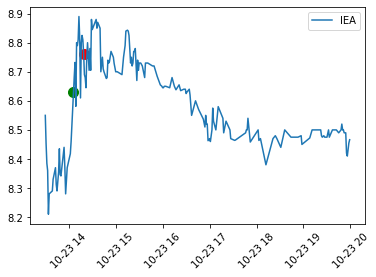

JDST analysis with profit -15.15


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-3229.98,-3229.98,buy,2020-10-23 10:23:00-04:00,10.66,303,0.46%,,"{'avg': 10.586227923067625, 'macd': [-0.0019655615755542755, 0.0005478116709571879, 0.0017130150786677234, 0.005797285382959316, 0.010207499605602521], 'vwap': 10.653233333333333, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.007426219759037383, 0.006050538141421344, 0.005183033528870619, 0.0053058838996883585, 0.006286207040871191]}",11.64,10.33
1,-15.15,3214.83,sell,2020-10-23 15:59:00-04:00,10.61,303,-0.01%,,{'liquidate': 1},None,None


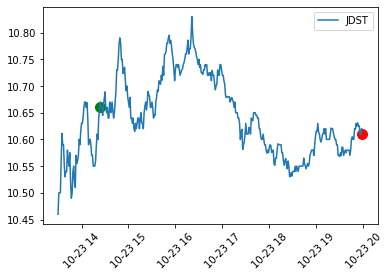

MFA analysis with profit 8.43


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2469.99,-2469.99,buy,2020-10-23 10:01:00-04:00,2.93,843,1.91%,,"{'avg': 2.8923940555082517, 'macd': [0.008540763803186024, 0.008207075298905409, 0.008250970911803712, 0.01036113447277165, 0.01251854313765799], 'vwap': 2.930733333333334, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.010320636012213514, 0.009897923869551893, 0.009568533278002257, 0.009727053516956135, 0.010285351441096506]}",3.29,2.81
1,8.43,2478.42,sell,2020-10-23 15:59:00-04:00,2.94,843,2.26%,,{'liquidate': 1},None,None


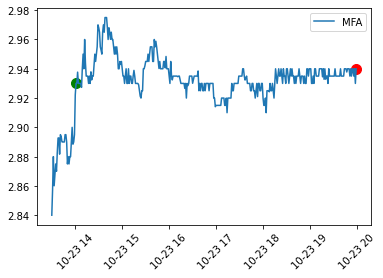

MRIN analysis with profit 57.39


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-794.60,-794.60,buy,2020-10-23 10:05:00-04:00,2.74,290,9.16%,,"{'avg': 2.5507641190471464, 'macd': [0.016239426903486898, 0.016455164281503176, 0.0202417942582227, 0.027939674789746682, 0.04162958489518864], 'vwap': 2.7059333333333337, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.023657107135016252, 0.022216718564313637, 0.02182173370309545, 0.023045321920425695, 0.026762174515378285]}",3.77,2.40
1,-363.95,430.65,sell,2020-10-23 10:10:00-04:00,2.97,145,18.33%,,"{'avg': 2.6705368828987943, 'rsi': [66.88029352952714, 69.69741085805936, 76.82251730494716], 'vwap': 2.9426, 'reasons': 'scale-out', 'movement': 0.08313868613138678, 'sell_macd': [0.02922502553329487, 0.03396920254488478, 0.03826376641696916, 0.043710650389801486, 0.0547950969869464], 'sell_macd_signal': [0.017653788441361073, 0.020916871262065814, 0.02438625029304648, 0.028251130312397482, 0.03355992364730727]}",3.77,2.40
2,42.05,406.00,sell,2020-10-23 10:18:00-04:00,2.80,145,11.55%,,"{'avg': 2.791324897271489, 'rsi': [61.320413265536, 61.33602200982897, 55.68902894430499], 'vwap': 2.8066666666666666, 'reasons': 'bail', 'movement': -0.05654019812655845, 'sell_macd': [0.06049444962369099, 0.05626021511501289, 0.0558509386781858, 0.054822269523798095, 0.050018688327429395], 'sell_macd_signal': [0.05297908246531206, 0.05363530899525223, 0.05407843493183894, 0.05422720185023077, 0.05338549914567049]}",3.77,2.40
3,-407.77,-449.82,buy,2020-10-23 10:22:00-04:00,3.06,147,21.91%,,"{'avg': 2.8384252906754974, 'macd': [0.08388323001076659, 0.08095369192089574, 0.08491540775451911, 0.09502084998593929, 0.10385763976855067], 'vwap': 3.078333333333333, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.08819633854977944, 0.0867478092240027, 0.08638132893010599, 0.08810923314127264, 0.09125891446672825]}",5.09,2.39
4,-169.79,237.98,sell,2020-10-23 10:24:00-04:00,3.26,73,29.88%,,"{'avg': 2.882686652453977, 'rsi': [68.72045761272484, 68.9293853006426, 75.5991298550508], 'vwap': 3.2066666666666666, 'reasons': 'scale-out', 'movement': 0.06362153344208804, 'sell_macd': [0.05006308969331785, 0.056512653538243196, 0.06210825324158442, 0.06592160037092087, 0.07513648211190693], 'sell_macd_signal': [0.05175289072315431, 0.05270484328617209, 0.054585525277254555, 0.056852740295987816, 0.06050948865917164]}",5.09,2.39
5,57.39,227.18,sell,2020-10-23 10:31:00-04:00,3.07,74,22.31%,,"{'avg': 2.9824943482641606, 'rsi': [68.37085766138925, 59.24832491451958, 55.27384052957689], 'vwap': 3.0766666666666667, 'reasons': 'bail', 'movement': -0.058282208588957045, 'sell_macd': [0.0885481124167522, 0.09317683806609267, 0.09297095106472053, 0.08537453325761568, 0.07557592371193733], 'sell_macd_signal': [0.07427268466849556, 0.07805351534801498, 0.08103700249135609, 0.081904508644608, 0.08063879165807387]}",5.09,2.39


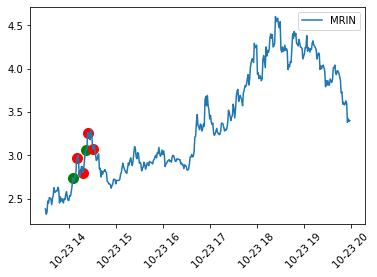

NBEV analysis with profit 101.37


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2476.65,-2476.65,buy,2020-10-23 09:59:00-04:00,2.85,869,2.89%,,"{'avg': 2.7925861860736383, 'macd': [0.016625669591880943, 0.016354657021340646, 0.016833440255004994, 0.018213302443716106, 0.019732985897051414], 'vwap': 2.844366666666667, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.01776074600782849, 0.01747952821053092, 0.017350310619425734, 0.017522908984283807, 0.017964924366837328]}",3.19,2.73
1,78.21,2554.86,sell,2020-10-23 10:12:00-04:00,2.94,869,6.14%,,"{'avg': 2.839593080412547, 'rsi': [72.86932725252815, 76.58208798970058, 80.22499225664565], 'vwap': 2.9416666666666664, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.034022681787858486, 'sell_macd': [0.014666279345414868, 0.014896146416464084, 0.015468820154730167, 0.016753126702018672, 0.018661853102043935], 'sell_macd_signal': [0.014739102130706996, 0.014770510987858414, 0.014910172821232765, 0.015278763597389947, 0.015955381498320743]}",3.19,2.73
2,-1075.93,-1154.14,buy,2020-10-23 10:22:00-04:00,2.99,386,7.94%,,"{'avg': 2.8597060027219428, 'macd': [0.029848067302972403, 0.029744777598438965, 0.030122601589491538, 0.03087306082362673, 0.03342258802047171], 'vwap': 2.9796666666666667, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.030907827267248788, 0.030675217333486823, 0.030564694184687765, 0.030626367512475557, 0.031185611614074786]}",3.76,2.73
3,101.37,1177.30,sell,2020-10-23 10:24:00-04:00,3.05,386,10.11%,,"{'avg': 2.895173970516402, 'rsi': [73.99857301540426, 77.26487961800085, 80.63954997149567], 'vwap': 3.0361666666666665, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.019906323185011822, 'sell_macd': [0.017522783886424254, 0.01798412920794501, 0.01961655245578031, 0.021984459500121734, 0.024643636510862432], 'sell_macd_signal': [0.01797694289764474, 0.017978380159704793, 0.018306014618919897, 0.019041703595160265, 0.020162090178300698]}",3.76,2.73


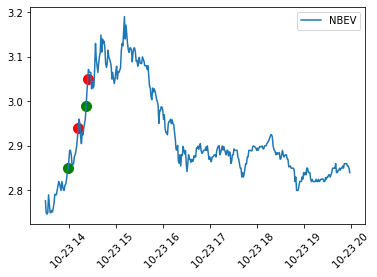

NEX analysis with profit -103.60


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1583.60,-1583.60,buy,2020-10-23 10:02:00-04:00,2.14,740,3.83%,,"{'avg': 2.079911337774703, 'macd': [0.009212283728677662, 0.00933482397859553, 0.010919893131908776, 0.013233894398671175, 0.016092625939311933], 'vwap': 2.1350000000000002, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.012384449809076428, 0.011774524642980249, 0.011603598340765953, 0.011929657552346998, 0.012762251229739984]}",2.54,2.01
1,-103.60,1480.00,sell,2020-10-23 14:13:00-04:00,2.00,740,-2.96%,,"{'avg': 2.0869988164690367, 'rsi': [48.13378885059784, 42.3013350669316, 39.412021668089295], 'vwap': 2.0066666666666664, 'reasons': 'stopped', 'movement': -0.06308411214953281, 'sell_macd': [-0.002595548446696405, -0.0022098361933253763, -0.0019377248764995691, -0.002162862488368944, -0.00248336544365646], 'sell_macd_signal': [-0.0025527789591025057, -0.0024841904059470796, -0.0023748973000575777, -0.0023324903377198508, -0.0023626653589071725]}",2.54,2.01


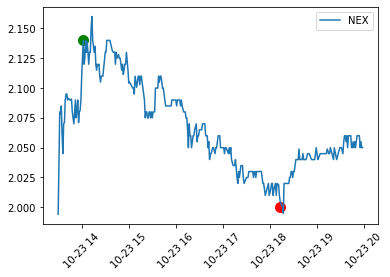

UE analysis with profit -39.72


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-3511.91,-3511.91,buy,2020-10-23 10:30:00-04:00,10.61,331,1.24%,,"{'avg': 10.54189902740494, 'macd': [0.002590356079654299, 0.003010705816270942, 0.004103450415428256, 0.004912826378696167, 0.007884128613406816], 'vwap': 10.604999999999999, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.00496862813336012, 0.004577043669942284, 0.004482325019039479, 0.004568425290970816, 0.005231565955458016]}",11.52,10.31
1,-39.72,3472.19,sell,2020-10-23 15:59:00-04:00,10.49,331,0.1%,,{'liquidate': 1},None,None


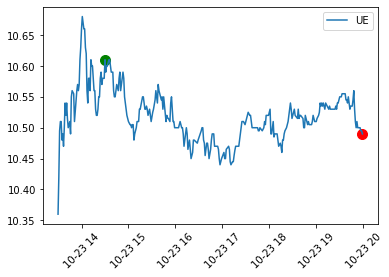

XHR analysis with profit -69.84


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2811.06,-2811.06,buy,2020-10-23 10:15:00-04:00,9.66,291,2.55%,,"{'avg': 9.472460352874918, 'macd': [0.039033165560290684, 0.0447052304537614, 0.04704425302894499, 0.04993614532541102, 0.05163280002691195], 'vwap': 9.643333333333333, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.04916739493463791, 0.04827496203846261, 0.04802882023655909, 0.04841028525432948, 0.04905478820884597]}",10.69,9.32
1,-69.84,2741.22,sell,2020-10-23 15:59:00-04:00,9.42,291,0.0%,,{'liquidate': 1},None,None


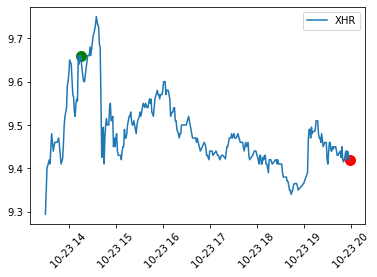

In [10]:
for symbol in minute_history:
    symbol_df = trades.loc[trades["symbol"] == symbol]
    start_date = symbol_df["client_time"].min()
    start_date = start_date.replace(hour=9, minute=30)
    end_date = start_date.replace(hour=16, minute=0)
    cool_down_date = start_date + timedelta(minutes=5)
    minute_history_index = minute_history[symbol]["close"].index.get_loc(
        start_date, method="nearest"
    )
    end_index = minute_history[symbol]["close"].index.get_loc(
        end_date, method="nearest"
    )
    cool_minute_history_index = minute_history[symbol]["close"].index.get_loc(
        cool_down_date, method="nearest"
    )
    open_price = minute_history[symbol]["close"][cool_minute_history_index]
    plt.plot(
        minute_history[symbol]["close"][minute_history_index:end_index].between_time(
            "9:30", "16:00"
        ),
        label=symbol,
    )
    plt.xticks(rotation=45)

    delta = 0
    profit = 0

    operations = []
    deltas = []
    profits = []
    times = []
    prices = []
    qtys = []
    indicators = []
    target_price = []
    stop_price = []
    daily_change = []
    precent_vwap = []
    patterns = []
    for index, row in symbol_df.iterrows():
        if (
            row["operation"] == "buy"
            and row["qty"] > 0
            or row["operation"] == "sell"
            and row["qty"] < 0
        ):
            try:
                now = int(row["client_time"])
                continue
            except Exception:
                pass

        delta = (
            row["price"]
            * row["qty"]
            * (1 if row["operation"] == "sell" and row["qty"] > 0 else -1)
        )
        profit += delta
        plt.scatter(
            row["client_time"].to_pydatetime(),
            row["price"],
            c="g" if row["operation"] == "buy" else "r",
            s=100,
        )
        deltas.append(round(delta, 2))
        profits.append(round(profit, 2))
        operations.append(row["operation"])
        times.append(pd.to_datetime(row["client_time"]))
        prices.append(row["price"])
        qtys.append(row["qty"])
        indicator = json.loads(row.indicators)
        indicators.append(indicator)
        target_price.append(row["target_price"])
        stop_price.append(row["stop_price"])
        daily_change.append(
            f"{round(100.0 * (float(row['price']) - open_price) / open_price, 2)}%"
        )
        precent_vwap.append(
            f"{round(100.0 * (indicator['buy']['avg'] - open_price) / open_price, 2)}%"
            if 'buy' in indicator and indicator['buy'] and "avg" in indicator['buy']
            else ""
        )

    d = {
        "profit": profits,
        "trade": deltas,
        "operation": operations,
        "at": times,
        "price": prices,
        "qty": qtys,
        "daily change": daily_change,
        "vwap": precent_vwap,
        "indicators": indicators,
        "target price": target_price,
        "stop price": stop_price,
    }
    print(f"{symbol} analysis with profit {round(profit, 2)}")
    display(HTML(pd.DataFrame(data=d).to_html()))
    plt.legend()
    plt.show()